# Bayesian Statistical Inference: V

*Davide Gerosa (Milano-Bicocca)* 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.

This course is based on previous work by many people. See [here]((https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/README.md) for credits.

Make sure the python package `dynesty` is installed. If you're running this notebook through binder, things should just work...

##  Practical Evidence Evaluation & Model Selection <a class="anchor" id="two"></a>

We've discussed Bayesian parameter estimation algorithms in detail. But what about evidence evaluation and model comparison? We already have the AIC and BIC as proxies. Grid-based methods for integrating the likelihood $\times$ prior are far too crude. 

There are some further numerical techniques that we'll briefly discuss, before looking at examples of **Nested Sampling** algorithms to compute the Bayesian evidence. 

### Savage-Dickey Density Ratio

This is great for when we want to compare models that have nested parameters, e.g. (1) a model with just noise, and (2) a model with a signal and noise. 

We need to be able to identify a parameter in the signal model that acts as an amplitude, $A$, that can effectively switch the signal off when it is zero. 

Thus $p_1(d|n) = p_2(d|A=0,n)$.


An example from my research field, gravitational-astronomy, is testing General Relativity. Suppose you want to test a theory which is more generic than GR (say the graviton has a non-zero mass, which implies a dispersion relation for the emitted waves), in that case GR is a special case ($m=0$) of the more generic theory.


With MCMC sampling we can map out the full parameter posterior distribution of model (2). We need to make sure we get good mixing and exploration of the parameter $A$ so that we can reconstruct its posterior density at $A=0$. 

The Bayes factor of Model $2$ (signal and noise) versus Model $1$ (noise alone) can be computed using the **[Savage-Dickey Density Ratio](https://www.jstor.org/stable/2958475?casa_token=Dc8wjaKRj5UAAAAA%3A4IhKgqNXc4jpan6hRxW7tBpXTI4i2236BulPTRxj4FcivD988vqJw-N75Dtw7z4Lh3YtPsDIceS8NDtIXAIRIO1T227h9VYZ2prQpwb46WLBB0GGz8w&seq=1#metadata_info_tab_contents)** approximation,

$$ \mathcal{B} = \frac{\mathcal{Z}_2}{\mathcal{Z}_1} = \frac{p(A=0)}{p(A=0|d,n)}$$

which is the prior density at $A=0$ divided by the conditional posterior density at $A=0$. We can easily compute the latter by making a histogram of posterior samples in $A$ and reading off the normalized pdf at $A=0$.


### Product-space Sampling

Product-space sampling sounds fancy, but is super easy. In this type of model comparison, we never explicitly try to compute the Bayesian evidence. 

- We run a big MCMC chain that includes all parameters of all models, in addition to a model indexing parameter, $n$. 
- We define distinct ranges for this parameter, such that in certain sampling ranges it will trigger one of the model likelihoods to be used, e.g. if $-0.5<n<0.5$ use the likelihood for model $1$. 
- After sampling sufficiently long, the MCMC chain will spend different amounts of time in differnt regions of $n$ in proportion to the Bayesian odds ratio. 
- Hence, the ratio of samples in model sub-ranges of $n$ gives the Bayesian odds ratio. Simple!
- This is heavily used in gravitational-wave searches for Pulsar Timing arrays, see [https://arxiv.org/abs/1801.02617](https://arxiv.org/abs/1801.02617), [https://arxiv.org/abs/2009.04496](https://arxiv.org/abs/2009.04496), and [https://arxiv.org/abs/2006.04810](https://arxiv.org/abs/2006.04810). 
- Refs [here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02042.x) and [here](https://amstat.tandfonline.com/doi/abs/10.1198/10618600152627924?casa_token=Kgpt2ZvdMrcAAAAA%3Al5JB7EitQ7MjPmxBObu2XJXocZCE1tI2-ZAceCwBjJOi2TRajF7SaxFcQjo1Nn5AF9q6vKhkxpBd&#.YEZH4F1KiLo).

### Thermodynamic Integration

This technique is pretty fancy, and is derived from analogies with thermodynamics. It is used for exact calculation of the Bayesian evidence. 

- Many MCMC chains are launched in parallel. However, their likelihoods differ slightly in their "temperature", $T$. We actually use the inverse temperature $\beta=1/T$ when writing the math. The temperature of a chain is used to modify the likelihood as follows, where 

$$ p(d|\theta)_\beta = p(d|\theta)^\beta = p(d|\theta)^{1/T}.$$

- Thus only the $T=0$ chain corresponds to the actual model likelhiood. 
- But the other temperature chains have the effect of taking higher and higher roots of the likelihood, smoothing it out and making it more similar to the original prior. 
- These high temperature chains explore the parameter volume well, communicate back to the $T=0$ chain, and improve MCMC mixing. 
- Crucially, we can also use them in evidence computation:

$$ \ln\mathcal{Z} = \int_0^1 \langle \ln p(d|\theta)\rangle_\beta\, d\beta, $$

where we take the mean log-likelihood of each $\beta$ chain, then sum these over all temperatures to get the log-evidence. Refs [here](https://www.jstor.org/stable/2676756?casa_token=nGU-oa0w6lQAAAAA%3A8UNqj0_rBP7aZ4vocZ_NzbxKhre4WvzhbNOs_TTI_FfexQmppcxQSlxaO5PCHPZNAw9fZUmy4rPeXLe_CVJgAD2AYR6qS8D6xQDicpc1R45ZhjEtOV4&seq=1#metadata_info_tab_contents), and [here](https://link.springer.com/content/pdf/10.1007/BF01406511.pdf).




### Nested Sampling

Nested sampling is a very different MCMC method from Metropolis-Hastings or even Gibbs approaches. 

- One starts with many points spread throughout the prior volume.
- The points are ranked in terms of their likelihood.
- The lowest ranked point is removed, and a higher likelihood point is randomly added.
- This is repeated, until the cluster of points climbs up the likelihood surface, accumulating Bayesian evidence information along the way. 

The prior volume is defined as $dX = p(\theta)d^n\theta$ such that $X(\lambda) = \int_{p(d|\theta)>\lambda}p(\theta)d^n\theta$, where the integral is over the model parameter region that exceeds the iso-likelihood contour $p(d|\theta)=L(\theta)=\lambda$.

This transforms the evidence integral into 

$$\mathcal{Z} = \int p(d|\theta)p(\theta)d^n\theta = \int_0^1 L(X)dX.$$


Here is how the algorithm works:


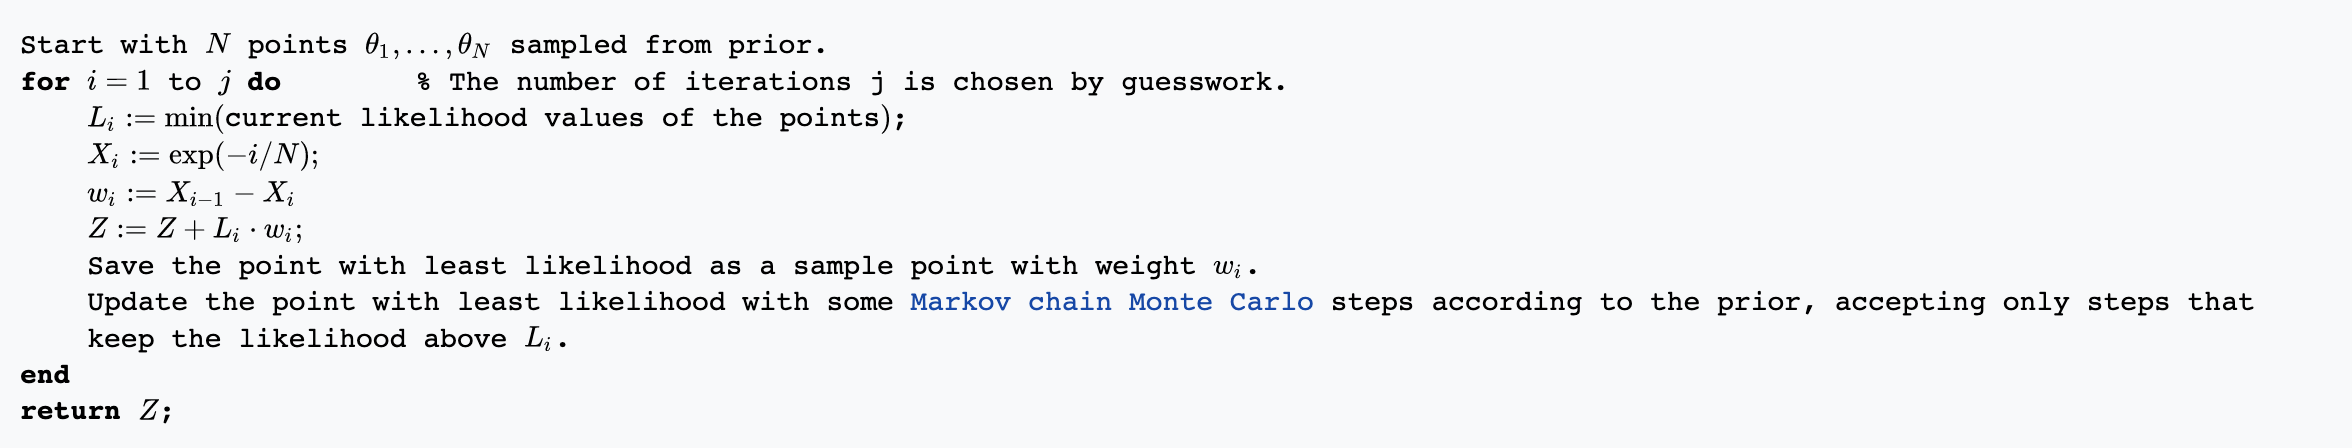

([credits](https://en.wikipedia.org/wiki/Nested_sampling_algorithm))


This paper is a nice example from the field of cosmology: https://arxiv.org/abs/astro-ph/0508461

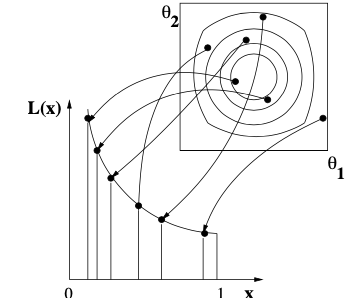


There are several popular packages that perform nested sampling, and not only do they all compute the Bayesian evidence but they also produce posterior samples as a by-product. 


By far the most historically well known is [`MultiNest`](https://github.com/rjw57/MultiNest) and its Python wrapper [`PyMultiNest`](https://johannesbuchner.github.io/PyMultiNest/). It used to be (and may still be) a bit of a pain to install though (there is C and Fortran involved). Refs [here](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S/abstract), and [here](https://academic.oup.com/mnras/article/398/4/1601/981502?login=true).


So while this is the big one, there seem to be other more pythonic implementations now on the market. Let's look at one in particular, which is used in my research field.

---

### Dynesty <a class="anchor" id="twoa"></a>

https://arxiv.org/abs/1904.02180

![](https://github.com/joshspeagle/dynesty/blob/master/docs/images/title.gif?raw=true)

This example comes from the [dynesty](https://arxiv.org/abs/1904.02180) ["crash course"](https://dynesty.readthedocs.io/en/latest/crashcourse.html). We define our likelihood to be a $3$D correlated multivariate Gaussian distribution, and our prior to be uniform in each dimension from $-10$ to $10$.

In [2]:
import dynesty
import numpy as np

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Run the sampler. 

In [4]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

4794it [00:01, 2656.27it/s, +500 | bound: 9 | nc: 1 | ncall: 23965 | eff(%): 22.091 | loglstar:   -inf < -0.296 <    inf | logz: -9.101 +/-  0.183 | dlogz:  0.001 >  0.509]


You've just estimated the Bayesian evidence and posterior. Plot the results. These figures will have an $x$-axis that is $-\ln X$ which is a bit confusing to think about to begin with, but remember that we are moving up the likelihood contours when going from left to right on the graphs.

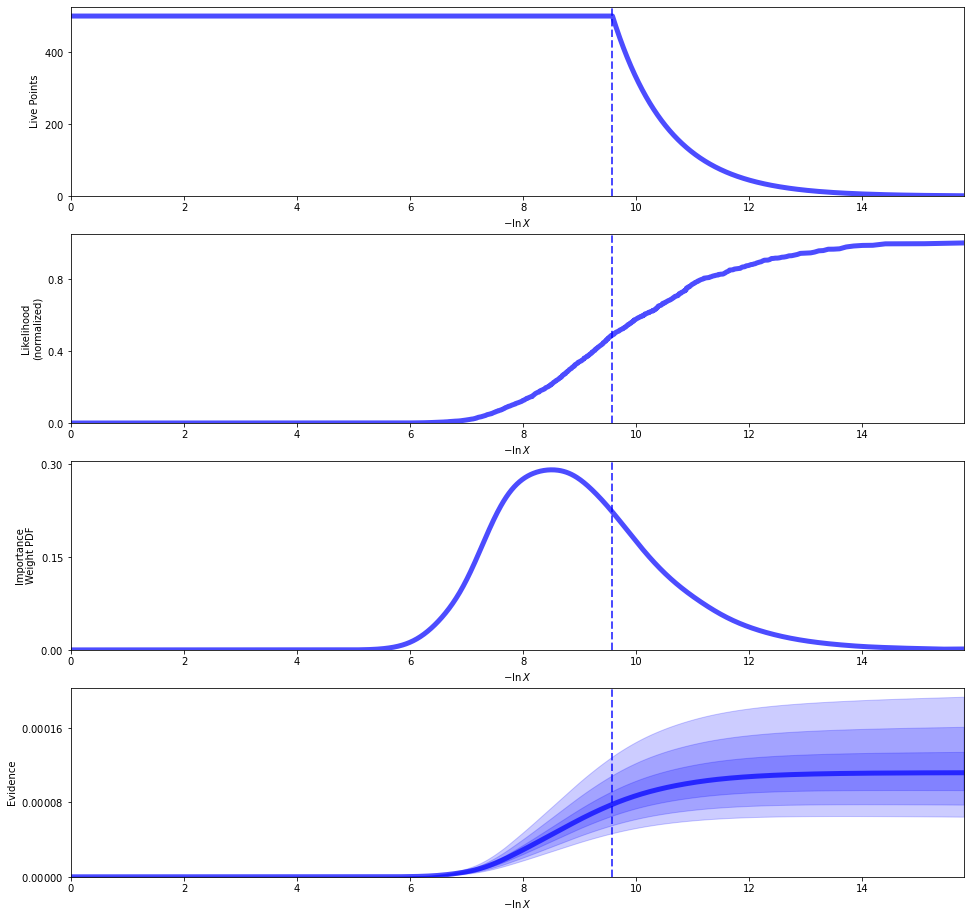

In [5]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

How to interpret this... (Figure from https://arxiv.org/abs/1904.02180)

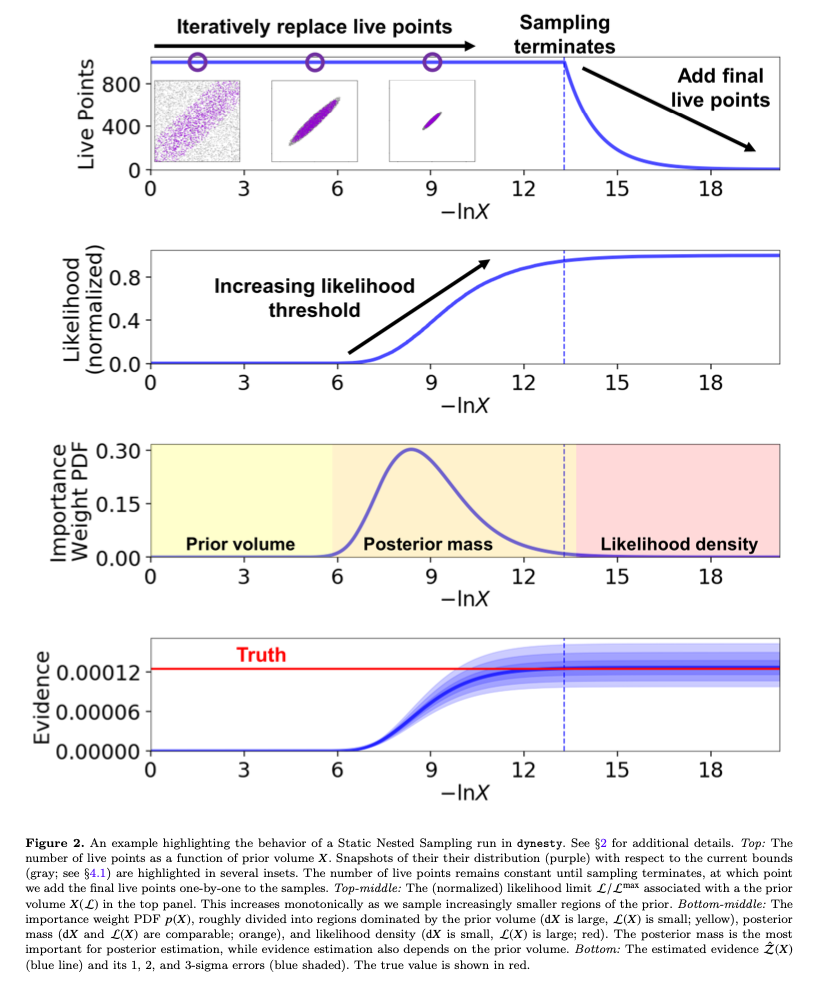

Plot parameter traces and 1-D marginalized posteriors. On the left panels, you'll see that the live points started out scattereed across the prior volume, then move inwards as the sampler climbs the likelihood.

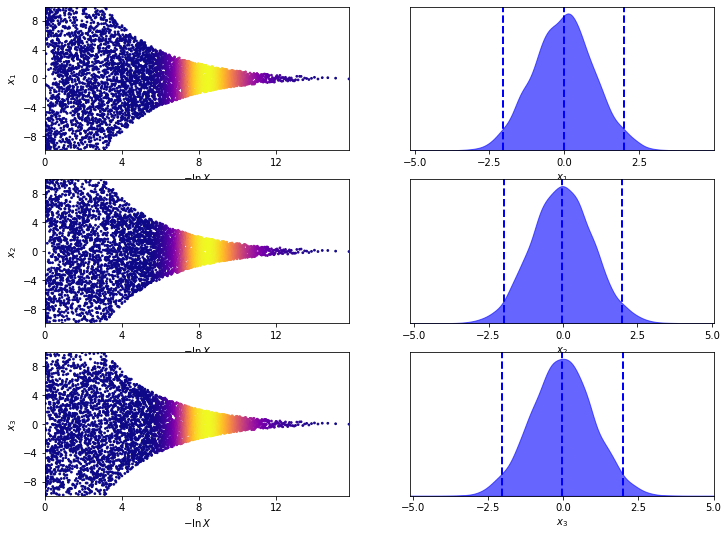

In [6]:
tfig, taxes = dyplot.traceplot(sresults)

Plot the 2-D marginalized posteriors using `dynesty` routines. (But you could also use `corner` if you wish).

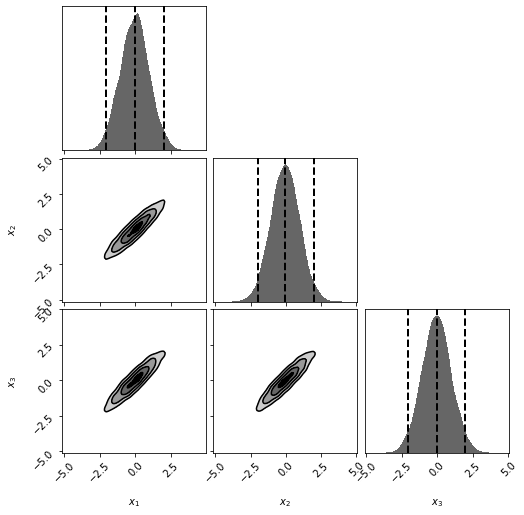

In [7]:
cfig, caxes = dyplot.cornerplot(sresults)

`dynesty` also lets you access many other utilities and analysis outputs. See below. 

In [9]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 0.00011154197921979234
68% parameter credible regions are:
 [[-1.065717380820144, 0.9594935546707863], [-1.0351186153689695, 0.9853269477471323], [-1.0648614437389192, 0.9578360435582248]]

Mean and covariance of parameters are: [-0.04230369 -0.03759367 -0.04143592]
[[1.03846665 0.98108329 0.99038118]
 [0.98108329 1.02264609 0.98679212]
 [0.99038118 0.98679212 1.04910779]]


If you want to plot your posterior samples using `corner` or another package, then access the *equally weighted samples*. 

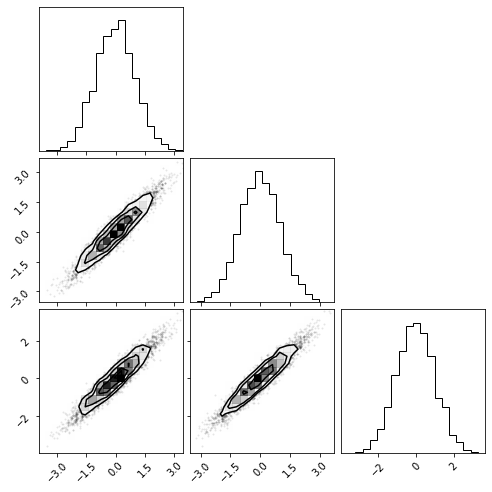

In [10]:
import corner
corner.corner(samples_equal);

The code even helpfully tells you what work you should be citing based on the run configurations that you used.

In [11]:
print(sampler.citations)

Code and Methods:
Speagle (2019): ui.adsabs.harvard.edu/abs/2019arXiv190402180S

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:



There is a lot to explore in the `dynesty` package. It is not a panacea, and there are some things you may have to tune, e.g. the **number of initialized live points**, and **the evidence tolerance**. Dig into these caveats in your own time for your own research problems.

Additionally, it implements **dynamic nested sampling** that dynamically allocates live points to explore higher posterior regions better at the expense of increasing the relative evidence uncertainty. See https://dynesty.readthedocs.io/en/latest/dynamic.html. 

In [12]:
## "Dynamic" nested sampling.

#dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
#dsampler.run_nested()
#dresults = dsampler.results

### Some harder examples... 

Have a look at some of these runs!

https://dynesty.readthedocs.io/en/latest/examples.html

###  UltraNest <a class="anchor" id="twob"></a>

*Refs: MLFriends (Buchner, 2014; 2019) using UltraNest https://johannesbuchner.github.io/UltraNest/*

If you want to explore another sampler for your research, I highly reccommend looking into UltraNest. 

This is a nice example from the [UltraNest's documentation](https://johannesbuchner.github.io/UltraNest/using-ultranest.html), which involves fitting a **spectral line feature**. There are many other tutorials on the documentation to dig into in your own time.

To see how `UltraNest` works compared to standard MCMC algorithms, go [here](https://johannesbuchner.github.io/UltraNest/method.html#visualisation). 



### Take home message


There is a ton more to explore in nested sampling, evidence evaluation, model comparison, and parameter estimation.

Alas, we must move on. However, these hands-on tutorials using real packages gives you an idea of the rich array of resources you can use for your own research.

Make sure you know what is going on under the hood, but remember we're physicists after all!

## Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

[My solution](https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/solutions/S10_transient2.ipynb) 